In [2]:
from __future__ import print_function

# Communication to TensorFlow server via gRPC
from grpc.beta import implementations
import tensorflow as tf
import numpy as np

# TensorFlow serving stuff to send messages
from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2
from scipy.io import loadmat
from copy import deepcopy
from flask import send_file
from itertools import groupby
from tqdm import tqdm
import random 
import pandas as pd

/home/olivier/anaconda3/envs/1.5_cpu/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [9]:
VOCAB_BASED_LANGUAGES = ["en"]

LANGUAGE = "en"
MODEL_NAME = "w2p_" + LANGUAGE

if LANGUAGE in VOCAB_BASED_LANGUAGES:
    VOCAB = "../api/word_to_phonetic/"+LANGUAGE+"/vocab"
else:
    VOCAB = None
    
DATASET = "../data_dir/"+LANGUAGE+"/dataset.csv" 

In [3]:
def _char_encode(input, padding_to = None):
    """
    Transform txt input to int tokens
    +2 is for special tokens ["<EOS>", "<PAD>"]
    + [1] is to add end of sequence "<EOS>" token

    :param input: String input
    :return: [1, -1, 1, 1] Int array
    """
    inp = [c + 2 for c in input.encode("Latin-1")] + [1]
    if padding_to:
        for _ in range(padding_to - len(inp)):
            inp += [0]
    inp = np.reshape(inp, [1, -1, 1, 1])

    return inp

def _char_decode(input):
    """
    Decode token ids to string and removes padding and eos

    :param input: int array
    :return: String
    """

    return [chr(idx - 2) for idx in input if idx > 1]

def _vocab_encode(input, vocab, padding_to = None):
    with open(vocab, "r") as f:
        vocab_arr = [l.strip()[1:-1] for l in f.readlines()]
    
    try :
        inp = [np.where(np.array(vocab_arr) == (c.upper() + "_"))[0][0] for c in input] + [1]
    except :
        print(input)
    if padding_to:
        for _ in range(padding_to - len(inp)):
            inp += [0]
    inp = np.reshape(inp, [1, -1, 1, 1])
    return inp

def _vocab_decode(input, vocab):
    with open(vocab, "r") as f:
        vocab_arr = [l.strip()[1:-1] for l in f.readlines()]
    return [vocab_arr[i][:-1] for i in input if i>1]

def _create_translate_request(input, model_name):
    """
    Creates translate request to TensorFlow serving server

    :param input: Int array, token ids
    :param model_name: Name of the model to serve
    :return: PredictRequest object
    """
    # create predict request
    request = predict_pb2.PredictRequest()

    # Call model to make phonetic translation
    request.model_spec.name = model_name
    request.model_spec.signature_name = "get_phon"
    request.inputs['input'].CopyFrom(
        tf.contrib.util.make_tensor_proto(input, dtype=tf.int32))

    return request


def _create_att_mats_request(input, phon, model_name):
    """
    Creates attention matrices request to TensorFlow serving server

    :param input: Int array, token ids
    :param phon: Int array, token ids, result of the phonetic translation
    :param model_name: name of the model to serve
    :return: PredictRequest object
    """

    # create predict request
    request = predict_pb2.PredictRequest()

    # Call model to get the correct attention matrices
    request.model_spec.name = model_name
    request.model_spec.signature_name = "get_att_mats"
    request.inputs["input"].CopyFrom(
        tf.contrib.util.make_tensor_proto(input, dtype=tf.int32))
    request.inputs["phon"].CopyFrom(
        tf.contrib.util.make_tensor_proto(phon, dtype=tf.int32))

    return request

def _open_tf_server_channel(server_name, server_port):
    """
    Opens channel to TensorFlow server for requests

    :param server_name: String, server name (localhost, IP address)
    :param server_port: String, server port
    :return: Channel stub
    """
    channel = implementations.insecure_channel(
        server_name,
        int(server_port))
    stub = prediction_service_pb2.beta_create_PredictionService_stub(channel)

    return stub

def _format_phon(phon):
    values = phon.int_val
    shape1 = phon.tensor_shape.dim[0].size
    shape2 = phon.tensor_shape.dim[1].size

    return np.reshape(values, [shape1, shape2])

def _format_att_mat(att_mat):
    values = att_mat.float_val
    shape1 = att_mat.tensor_shape.dim[0].size
    shape2 = att_mat.tensor_shape.dim[1].size
    
    if len(att_mat.tensor_shape.dim) == 2:
        return np.reshape(values, [shape1, shape2])
    elif len(att_mat.tensor_shape.dim) == 3:
        shape3 = att_mat.tensor_shape.dim[2].size
        return np.reshape(values, [shape1, shape2, shape3])


def _make_translation(input, model_name, stub):
    translation_request = _create_translate_request(input, model_name)
    translation_results = stub.Predict(translation_request, 60.0)
    return _format_phon(translation_results.outputs["phon"])


def _make_att_matrices(input, phon, model_name, stub):
    att_mats_request = _create_att_mats_request(input, phon, model_name)
    att_mats_results = stub.Predict(att_mats_request, 60.0)

    att_mats = []
    att_mats.append(_format_att_mat(att_mats_results.outputs["att_mat_inp_out_layer_0"]))
    att_mats.append(_format_att_mat(att_mats_results.outputs["att_mat_inp_out_layer_4"]))
    att_mats.append(_format_att_mat(att_mats_results.outputs["att_mat_inp_out_layer_5"]))

    return np.array(att_mats)


def _make_prediction(input, model_name, stub, vocab=None):
    if not vocab:
        input_tokenized = _char_encode(input)
    else:
        input_tokenized = _vocab_encode(input, vocab)

    phon_tokenized = np.squeeze(_make_translation(input_tokenized, model_name, stub))

    if not vocab:
        phon = _char_decode(phon_tokenized)
    else:
        phon = _vocab_decode(phon_tokenized, vocab)

    att_mats = _make_att_matrices(input_tokenized, np.reshape(phon_tokenized, [1, -1, 1, 1]), model_name, stub)

    sum_all_layers = _normalize(np.sum(np.array(att_mats), axis=0)[:len(phon), :len(input)])

    return phon, sum_all_layers

def _make_prediction_batch(batch_input, model_name, stub, vocab=None):
    padding_to = len(max(batch_input, key=len)) + 1
    
    if not vocab:
        batch_input_tokenized = np.stack([_char_encode(input, padding_to).squeeze(0) for input in batch_input], 0)

    else:
        batch_input_tokenized = np.stack([_vocab_encode(input, vocab, padding_to).squeeze(0) for input in batch_input], 0)

    batch_phon_tokenized = _make_translation(batch_input_tokenized, model_name, stub)

    if not vocab:
        batch_phon = [_char_decode(phon_tokenized) for phon_tokenized in batch_phon_tokenized]
    else:
        batch_phon = [_vocab_decode(phon_tokenized, vocab) for phon_tokenized in batch_phon_tokenized]
    
    batch_att_mats = _make_att_matrices(batch_input_tokenized, np.reshape(batch_phon_tokenized, [len(batch_input), -1, 1, 1]), model_name, stub)

    batch_sum_all_layers = _normalize(np.sum(np.array(batch_att_mats), axis=0))

    return batch_phon, batch_sum_all_layers


def g2p_mapping_once(input, model_name, vocab=None):
    """
    Predict the phonetic translation of a word using a Transformer model

    :param input: String, word
    :param model_name: Name of the model to serve
    :return: Array[3], [0] input text, [1] phonetic translation, [2] mapping
    """

    # get TensorFlow server connection parameters
    server_name, server_port = "0.0.0.0", "9000"

    # open channel to tensorflow server
    stub = _open_tf_server_channel(server_name, server_port)

    # get phonetic translation and attention matrices
    phon, sum_all_layers = _make_prediction(input, model_name, stub, vocab)

    # make prediction

    return _mapping(input, phon, sum_all_layers)

def g2p_mapping_batch(batch_input, model_name, vocab=None):
    """
    Predict the phonetic translation of a word using a Transformer model

    :param input: String, word
    :param model_name: Name of the model to serve
    :return: Array[3], [0] input text, [1] phonetic translation, [2] mapping
    """

    # get TensorFlow server connection parameters
    server_name, server_port = "0.0.0.0", "9000"

    # open channel to tensorflow server
    stub = _open_tf_server_channel(server_name, server_port)

    # get phonetic translation and attention matrices
    batch_phon, batch_sum_all_layers = _make_prediction_batch(batch_input, model_name, stub, vocab)

    # make prediction
    return [_mapping(input, batch_phon[idx], batch_sum_all_layers[idx, :len(batch_phon[idx]), :len(input)]) for idx, input in enumerate(batch_input)]

def g2p_mapping_file(corpus, progression, model_name, vocab=None):
    gpProg = _load_gp_prog(progression)

    # get TensorFlow server connection parameters
    server_name, server_port = "0.0.0.0", "9000"

    # open channel to tensorflow server
    stub = _open_tf_server_channel(server_name, server_port)

    # get phonetic translation and attention matrices
    phon_results = []
    g_p_results = []
    for word in corpus:
        phon, sum_all_layers = _make_prediction(word, model_name, stub, vocab)
        phon_results.append(phon)
        g_p_results.append(_mapping(word, phon, sum_all_layers)[2])

    wordGp = list(zip(corpus, phon_results, deepcopy(g_p_results), deepcopy(g_p_results)))
    wordGp = _get_unique_words(wordGp)
    wordList = _generate_word_list(wordGp, gpProg)

    path = os.path.join(settings.FR_FILES, "results.csv")
    wordList.to_csv(path, encoding="UTF-8")
    return send_file(path)

def _normalize(matrix):
    """
        input: a numpy matrix
        return: matrix with 0 mean and 1 std
    """
    return (matrix - np.mean(matrix)) / (np.std(matrix) + 1e-10)


def _mapping(inp_text, out_text, sum_all_layers):
    # Base threshold
    # fr : 0.75
    # es : 0.4
    if len(out_text) > 4:
        threshold = 0.4
    else:
        threshold = 0

    # While we have too many silent_letters detected
    while (True):
        # Gets the silent_letters indices
        # We consider that a letter is silent if its attention value is below mean attention + threshold * std attention
        silent_letters_idx = [i for i, idx in enumerate(np.argmax(sum_all_layers, axis=0))
                              if sum_all_layers[idx, i] < np.mean(sum_all_layers[idx, :])
                              + threshold * np.std(sum_all_layers[idx, :])]
        # Reduces threshold if too many silent letters are detected
        # Can happen in french when we have 3 lettres graphemes
        if len(silent_letters_idx) > 1 / 3 * len(inp_text):
            threshold -= 0.1
        else:
            break

    # Creates the phoneme attribution list
    phon_list = np.array(out_text)[np.argmax(sum_all_layers, axis=0)]
    phon_list[silent_letters_idx] = "#"  # "#" is our encoding for silent letters
    phon_list = phon_list.tolist()  # needed for the += just below

    # Checks if all the phonemes are attributed and if they are only present the correct number of time in the list
    # If not, the phoneme is concatenated to its most probable neighbor
    # and the least probable phoneme is replaced by a silent letter (this can happen for small datasets)
    discard_next = False
    for i, phon in enumerate(out_text):
        if phon not in phon_list and not discard_next:
            probable_idx = np.argmax(sum_all_layers[i, :])
            if (i+1) < len(out_text) and phon_list[probable_idx] == out_text[i+1]:
                phon_list[probable_idx] = phon + phon_list[probable_idx]
                discard_next = True
            else:
                phon_list[np.argmax(sum_all_layers[i, :])] += phon
        elif discard_next:
            discard_next = False

    # test = np.where(np.array(phon_list) == phon)[0]
    #     if len(test > 1):
    #         phon_list[np.max(test)] = "%"

    ##NOT WORKING PROPERLY

    # Creates the g_p tupple list
    g_p = [(l, phon_list[i]) for i, l in enumerate(inp_text)]

    # Creates the final g_p mapping
    mapping = []
    for phon, letters in groupby(g_p, lambda x: x[1]):
        graph = "".join([letter[0] for letter in letters])
        mapping.append(graph + "~" + phon)

    return ["".join(inp_text), " ".join(out_text), mapping]

In [22]:
def plot_attention_matrix(inp_text, out_text, sum_all_layers):              
    from matplotlib import pyplot as plt
    source_len = len(inp_text)
    prediction_len = len(out_text)


    fig = plt.figure(figsize=(8, 8))
    plt.imshow(
      X=sum_all_layers,
      interpolation="nearest",
      cmap=plt.cm.Blues)
    plt.xticks(np.arange(source_len), inp_text, rotation=45)
    plt.yticks(np.arange(prediction_len), out_text, rotation=-45)
    fig.tight_layout()
    #fig.suptitle(("").join(inp_text) + " " + (" ").join(temp), fontsize=20)
    plt.show()

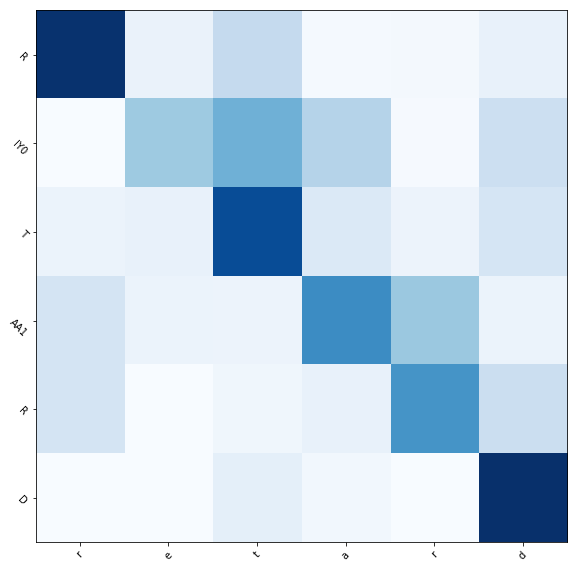

In [25]:
input = "retard"

# get TensorFlow server connection parameters
server_name, server_port = "0.0.0.0", "9000"

# open channel to tensorflow server
stub = _open_tf_server_channel(server_name, server_port)

# get phonetic translation and attention matrices
phon, sum_all_layers = _make_prediction(input, MODEL_NAME, stub, VOCAB)

# make prediction
inp_text = input
out_text = phon
plot_attention_matrix(inp_text, out_text, sum_all_layers)

In [14]:
# Base threshold
# fr : 0.75
# es : 0.4
if len(out_text) > 4:
    threshold = 0.4
else:
    threshold = 0

# While we have too many silent_letters detected
while (True):
    # Gets the silent_letters indices
    # We consider that a letter is silent if its attention value is below mean attention + threshold * std attention
    silent_letters_idx = [i for i, idx in enumerate(np.argmax(sum_all_layers, axis=0))
                          if sum_all_layers[idx, i] < np.mean(sum_all_layers[idx, :])
                          + threshold * np.std(sum_all_layers[idx, :])]
    # Reduces threshold if too many silent letters are detected
    # Can happen in french when we have 3 lettres graphemes
    if len(silent_letters_idx) > 1 / 3 * len(inp_text):
        threshold -= 0.1
    else:
        break

# Creates the phoneme attribution list
phon_list = np.array(out_text)[np.argmax(sum_all_layers, axis=0)]
phon_list[silent_letters_idx] = "#"  # "#" is our encoding for silent letters
phon_list = phon_list.tolist()  # needed for the += just below

# Checks if all the phonemes are attributed and if they are only present the correct number of time in the list
# If not, the phoneme is concatenated to its most probable neighbor
# and the least probable phoneme is replaced by a silent letter (this can happen for small datasets)
discard_next = False
for i, phon in enumerate(out_text):
    if phon not in phon_list and not discard_next:
        probable_idx = np.argmax(sum_all_layers[i, :])
        if (i+1) < len(out_text) and phon_list[probable_idx] == out_text[i+1]:
            phon_list[probable_idx] = phon + phon_list[probable_idx]
            discard_next = True
        else:
            phon_list[np.argmax(sum_all_layers[i, :])] += phon
    elif discard_next:
        discard_next = False

# test = np.where(np.array(phon_list) == phon)[0]
#     if len(test > 1):
#         phon_list[np.max(test)] = "%"

##NOT WORKING PROPERLY

# Creates the g_p tupple list
g_p = [(l, phon_list[i]) for i, l in enumerate(inp_text)]

# Creates the final g_p mapping
mapping = []
for phon, letters in groupby(g_p, lambda x: x[1]):
    graph = "".join([letter[0] for letter in letters])
    mapping.append(graph + "~" + phon)